In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
df_tcs = pd.read_csv('/content/drive/MyDrive/TCS.csv', parse_dates=['Date'], index_col='Date')
df_infosys = pd.read_csv('/content/drive/MyDrive/INFY.csv', parse_dates=['Date'], index_col='Date')

# Drop any rows with missing 'Close' values
df_tcs = df_tcs.dropna(subset=['Close'])
df_infosys = df_infosys.dropna(subset=['Close'])

# Train-Test Split
train_size_tcs = int(len(df_tcs) * 0.8)
train_size_infosys = int(len(df_infosys) * 0.8)

train_tcs = df_tcs.iloc[:train_size_tcs]
test_tcs = df_tcs.iloc[train_size_tcs:]

train_infosys = df_infosys.iloc[:train_size_infosys]
test_infosys = df_infosys.iloc[train_size_infosys:]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3311
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -16227.354
Date:                Mon, 28 Apr 2025   AIC                          32456.709
Time:                        12:22:56   BIC                          32462.814
Sample:                             0   HQIC                         32458.894
                               - 3311                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1060.8957      2.344    452.535      0.000    1056.301    1065.490
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):           8384254.03
Prob(Q):                              0.74   Pr

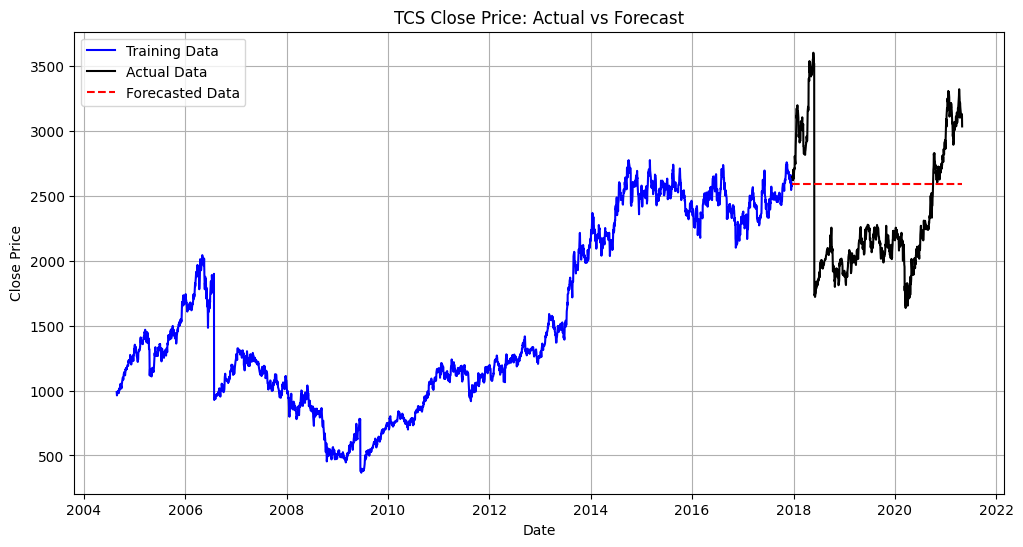

TCS ARIMA Model Evaluation
MAE: 495.76
MSE: 285230.05
RMSE: 534.07


In [10]:
# ARIMA Model for TCS
model_tcs = ARIMA(train_tcs['Close'], order=(0, 1, 0))
tcs_model_fit = model_tcs.fit()

# Print Model Summary
print(tcs_model_fit.summary())

# Forecast
forecast_tcs_series = tcs_model_fit.forecast(steps=len(test_tcs))
forecast_tcs_series.index = test_tcs.index

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_tcs['Close'], label='Training Data', color='blue')
plt.plot(test_tcs['Close'], label='Actual Data', color='black')
plt.plot(forecast_tcs_series, label='Forecasted Data', color='red', linestyle='--')
plt.title("TCS Close Price: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics
aligned_tcs = pd.concat([test_tcs['Close'], forecast_tcs_series], axis=1).dropna()
mae_tcs = mean_absolute_error(aligned_tcs.iloc[:, 0], aligned_tcs.iloc[:, 1])
mse_tcs = mean_squared_error(aligned_tcs.iloc[:, 0], aligned_tcs.iloc[:, 1])
rmse_tcs = np.sqrt(mse_tcs)

print("TCS ARIMA Model Evaluation")
print(f"MAE: {mae_tcs:.2f}")
print(f"MSE: {mse_tcs:.2f}")
print(f"RMSE: {rmse_tcs:.2f}")


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4444
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -27501.554
Date:                Mon, 28 Apr 2025   AIC                          55013.108
Time:                        12:23:10   BIC                          55045.104
Sample:                    01-03-2000   HQIC                         55024.389
                         - 01-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2993.8061      0.002   1.48e+06      0.000    2993.802    2993.810
ar.L1          0.9997      0.000   3534.617      0.000       0.999       1.000
ma.L1          0.1425      0.003     46.059      0.0

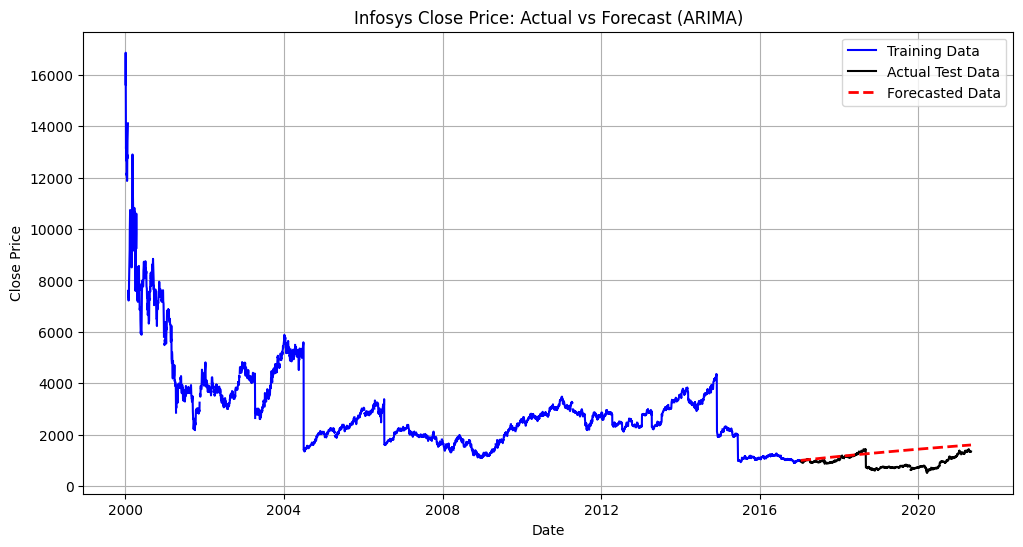

In [11]:

# Convert train test data to business day frequency
train_infosys = train_infosys.asfreq('B')
test_infosys = test_infosys.asfreq('B')


# Fit ARIMA Model
model_infosys = ARIMA(train_infosys['Close'], order=(1,0,2))
infosys_fit = model_infosys.fit()

# Print Model Summary
print(infosys_fit.summary())

# Forecast for the length of test data
forecast_step = len(test_infosys)
forecast_infosys = infosys_fit.forecast(steps=forecast_step)

# Create a Series with same index as test set
forecast_series_infosys = pd.Series(forecast_infosys, index=test_infosys.index)

# Align and clean data (very important!)
valid_indices = ~np.isnan(test_infosys['Close']) & ~np.isnan(forecast_series_infosys)
test_infosys_valid = test_infosys[valid_indices]
forecast_series_valid = forecast_series_infosys[valid_indices]

# Calculate error metrics
mae = mean_absolute_error(test_infosys_valid['Close'], forecast_series_valid)
mse = mean_squared_error(test_infosys_valid['Close'], forecast_series_valid)
rmse = np.sqrt(mse)

# Print Metrics
print("\nInfosys ARIMA Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_infosys.index, train_infosys['Close'], label="Training Data", color="blue")
plt.plot(test_infosys.index, test_infosys['Close'], label="Actual Test Data", color="black")
plt.plot(forecast_series_infosys.index, forecast_series_infosys, label="Forecasted Data", color="red", linestyle='--', linewidth=2)
plt.title("Infosys Close Price: Actual vs Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
